# Tune MNIST Predictor

This notebook aims to tune the MLP Keras model created on `train_mnist_predictor`

## Predict digits 

In [1]:
# Change the reference dir to the root folder
import os
os.chdir('../')

In [2]:
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from utils import plot_numbers, get_accuracy_by_digit

In [3]:
X, y = np.load('new_image_array.npy'), np.load('new_y_true.npy')

In [4]:
# Count numbers in database
pd.Series(y).value_counts().sort_values(ascending=False)

7.0    537
9.0    446
1.0    438
0.0    365
4.0    295
3.0    290
8.0    274
2.0    229
5.0    210
6.0    168
dtype: int64

In [5]:
# Frequency in % of numbers in database
(pd.Series(y).value_counts() / len(y)).sort_values(ascending=False)

7.0    0.165129
9.0    0.137146
1.0    0.134686
0.0    0.112239
4.0    0.090713
3.0    0.089176
8.0    0.084256
2.0    0.070418
5.0    0.064576
6.0    0.051661
dtype: float64

In [6]:
X_train_full, X_test_full, y_train_full, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

In [7]:
X_train_full.min(), X_train_full.max()

(0, 255)

The train set contains 60,000 images in 28x28 array. Each element of the array represents the pixel intensity of the image, ranging from 1 to 255

Let's see some of the pictures of the dataset

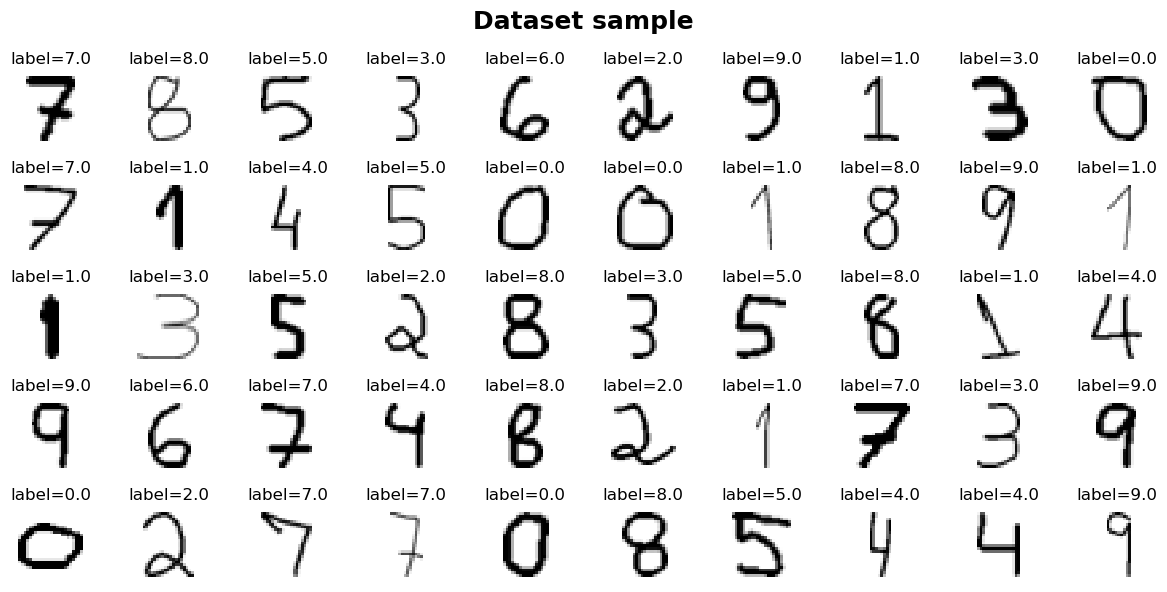

In [8]:
plot_numbers(X_train_full, true_label=y_train_full, title='Dataset sample', n_rows=5);

Normalizing array and creating validation set (the data is already shuffled)

In [9]:
# Creating validation set
X_train, X_valid = X_train_full[y_test.shape[0]:], X_train_full[:y_test.shape[0]]
y_train, y_valid = y_train_full[y_test.shape[0]:], y_train_full[:y_test.shape[0]]

In [10]:
# Normalizing values from 0-255 to 0-1
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test_full / 255.

## Data Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)

In [13]:
# train_generator = datagen.flow(X_train, y_train, batch_size=32)

**IN WORKS**

In [14]:
retrain = True

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [160]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
]
)

In [161]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [162]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 200)               157000    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 10)                510       
                                                                 
Total params: 182,660
Trainable params: 182,660
Non-trainable params: 0
_________________________________________________________________


In [187]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./models/tuned-mnist.h5", save_best_only=True)

In [188]:
if retrain:
    history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_valid, y_valid), epochs=100,
                        callbacks=[early_stopping_cb, checkpoint_cb])
else:
    model = tf.keras.models.load_model('./models/tuned-mnist.h5')

Epoch 1/100
22/82 [=======>......................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

KeyboardInterrupt: 

In [174]:
model = tf.keras.models.load_model('./models/tuned-mnist.h5')

In [9]:
if retrain:
    model.save("'./models/tuned-mnist.h5", save_format="tf")

In [175]:
y_pred = np.argmax(model.predict(X_test), axis=1)

11/11 [==============================] - 0s 2ms/step


In [176]:
print('Metrics:')
print(classification_report(y_test, y_pred))

Metrics:
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96        37
         1.0       0.96      0.98      0.97        54
         2.0       0.97      0.97      0.97        33
         3.0       0.96      0.96      0.96        27
         4.0       0.96      0.96      0.96        24
         5.0       0.90      0.90      0.90        21
         6.0       0.92      1.00      0.96        11
         7.0       0.96      0.96      0.96        52
         8.0       0.96      0.92      0.94        24
         9.0       0.98      0.98      0.98        43

    accuracy                           0.96       326
   macro avg       0.95      0.96      0.96       326
weighted avg       0.96      0.96      0.96       326



In [178]:
from sklearn.metrics import accuracy_score

In [182]:
df2 = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'right': y_pred == y_test})

In [184]:
df2.groupby('y_test')['right'].sum() / df2.groupby('y_test')['right'].count()

y_test
0.0    0.945946
1.0    0.981481
2.0    0.969697
3.0    0.962963
4.0    0.958333
5.0    0.904762
6.0    1.000000
7.0    0.961538
8.0    0.916667
9.0    0.976744
Name: right, dtype: float64

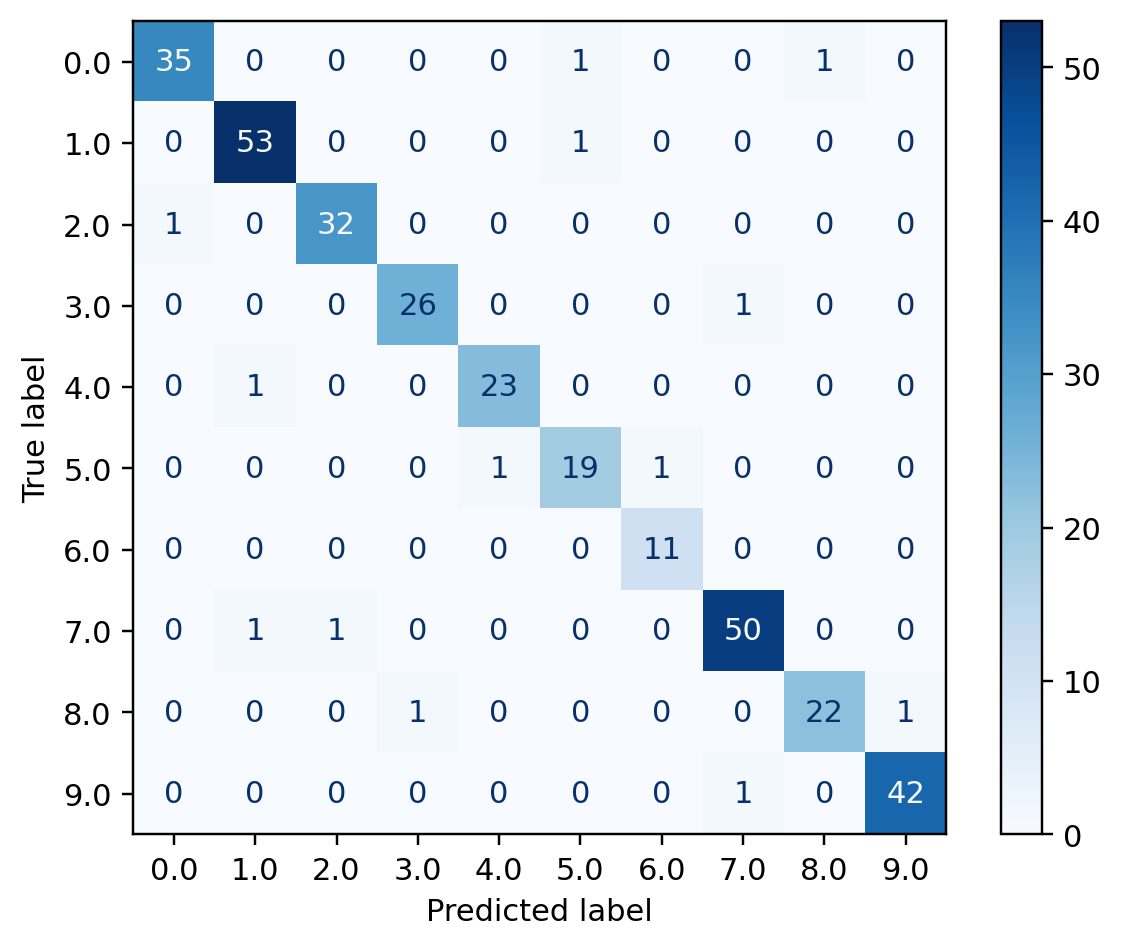

In [177]:
fig, ax = plt.subplots(dpi=220)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', ax=ax)
plt.show()

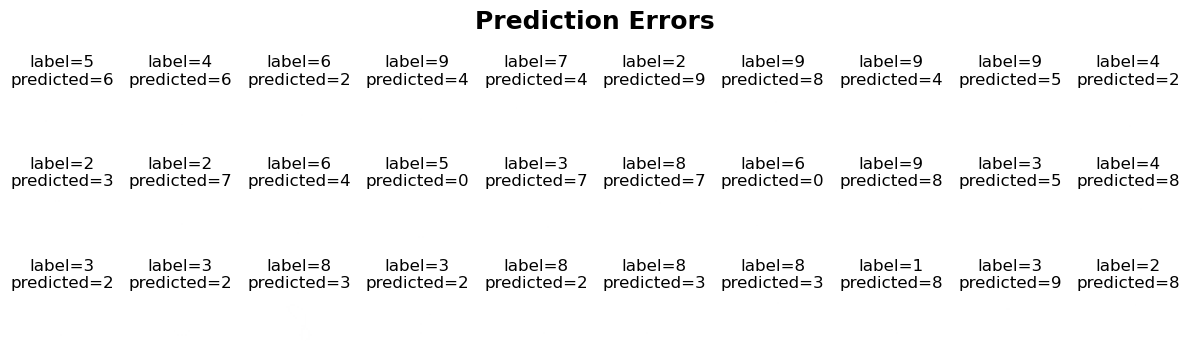

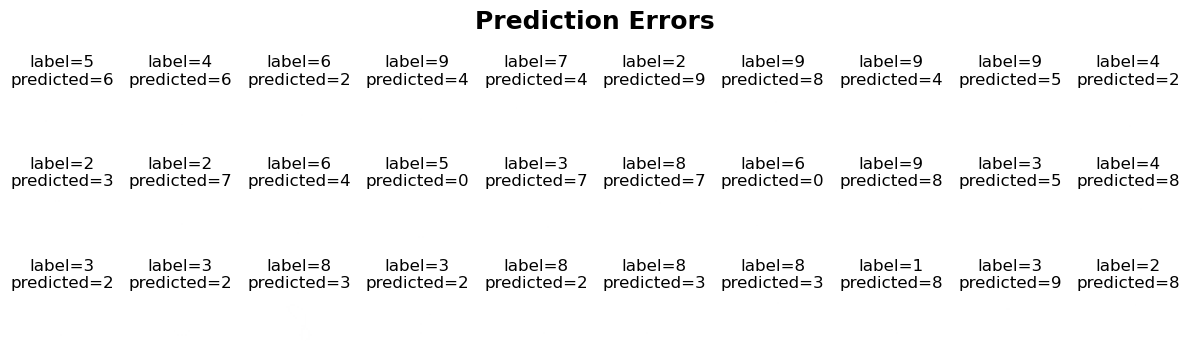

In [27]:
plot_numbers(
    img_array=X_test[y_pred != y_test],
    true_label=y_test[y_pred != y_test],
    predicted_label=y_pred[y_pred != y_test],
    title='Prediction Errors'
)

## Fine tune model

In [29]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [46]:
# Baseline model from previous notebook
model = tf.keras.models.load_model('./models/default_mnist.h5')

In [47]:
y_pred = np.argmax(model.predict(X_test), axis=1)

11/11 [==============================] - 0s 2ms/step


In [48]:
get_accuracy_by_digit(y_test, y_pred)

y_true
0.0    0.0
1.0    0.0
2.0    0.0
3.0    0.0
4.0    0.0
5.0    0.0
6.0    0.0
7.0    0.0
8.0    1.0
9.0    0.0
Name: right, dtype: float64

In [45]:
y_pred

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

In [33]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./models/tuned-mnist.h5", save_best_only=True)

In [34]:
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_valid, y_valid), epochs=100,
                     callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/100
82/82 [==============================] - 1s 8ms/step - loss: 1.6137 - accuracy: 0.4223 - val_loss: 0.3650 - val_accuracy: 0.9110
Epoch 2/100
82/82 [==============================] - 0s 6ms/step - loss: 0.2230 - accuracy: 0.9423 - val_loss: 0.1410 - val_accuracy: 0.9632
Epoch 3/100
82/82 [==============================] - 0s 5ms/step - loss: 0.1028 - accuracy: 0.9715 - val_loss: 0.0931 - val_accuracy: 0.9755
Epoch 4/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0508 - accuracy: 0.9904 - val_loss: 0.1047 - val_accuracy: 0.9663
Epoch 5/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0255 - accuracy: 0.9977 - val_loss: 0.0655 - val_accuracy: 0.9816
Epoch 6/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0129 - accuracy: 0.9988 - val_loss: 0.0771 - val_accuracy: 0.9724
Epoch 7/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0086 - accuracy: 0.9992 - val_loss: 0.0549 - val_accuracy: 0.9785
Epoch 8/100
8

In [35]:
model = tf.keras.models.load_model('models/tuned-mnist.h5')

In [36]:
y_pred = np.argmax(model.predict(X_test), axis=1)

11/11 [==============================] - 0s 2ms/step


In [37]:
get_accuracy_by_digit(y_test, y_pred)

y_true
0.0    0.945946
1.0    1.000000
2.0    0.969697
3.0    0.962963
4.0    0.916667
5.0    0.952381
6.0    1.000000
7.0    0.961538
8.0    0.958333
9.0    0.976744
Name: right, dtype: float64

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96        37
         1.0       0.95      1.00      0.97        54
         2.0       0.97      0.97      0.97        33
         3.0       1.00      0.96      0.98        27
         4.0       1.00      0.92      0.96        24
         5.0       1.00      0.95      0.98        21
         6.0       0.92      1.00      0.96        11
         7.0       0.96      0.96      0.96        52
         8.0       0.96      0.96      0.96        24
         9.0       0.95      0.98      0.97        43

    accuracy                           0.97       326
   macro avg       0.97      0.96      0.97       326
weighted avg       0.97      0.97      0.97       326

